In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy import integrate
from matplotlib import pyplot as plt

/home/jhummel/anaconda/envs/upgrading/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Each time a CR proton ionises an H atom, an electron with average energy ⟨E⟩=35eV is produced (Spitzer et al., 1968). Including the ionization energy of 13.6eV, the CR proton loses approximately 50eV per scattering. This necessarily places a limit on how many scatterings a CR proton can undergo before losing all its energy to ionisation, as well as limiting the distance it may travel. This distance may be described by a penetration depth
$$ D_p(n, \epsilon) \approx \frac{\beta c \epsilon} {-({\rm d}\epsilon / {\rm d}t)_{\rm ion}}$$

In [2]:
def Dp(n,epsilon):
    return beta(epsilon) * 2.99e10 * epsilon / dedt(n,epsilon)

where, according to Schlickeiser (2002):
$$\beta =  \sqrt{1 - \left( \frac{\epsilon}{m_{\rm \tiny H}c^2}+1 \right)^{-2}},$$

In [3]:
def beta(epsilon):
    mHc2 = 938272046 #rest energy of a proton in eV
    return np.sqrt(1 - (epsilon/mHc2 + 1)**(-2))

$$f(\epsilon) = (1 + 0.0185 \,{\rm ln}\beta )\, \frac{2 \beta^2}{\beta_0^3 + 2 \beta^3},$$

In [4]:
def f(epsilon):
    B0 = 0.01
    B = beta(epsilon)
    return (1 + 0.0185 * np.log(B)) * 2*B**2 / (B0**3 + 2*B**3)

and $$- \left( \frac{{\rm d}\epsilon} {{\rm d}t} \right)_{\rm ion}(n, \epsilon) = 1.82\times10^{-7}\,{\rm \small eV\,s}^{-1} n_{\rm \tiny H} f(\epsilon).$$

In [5]:
def dedt(n, epsilon):
    return 1.82e-7 * n * f(epsilon)

Here, $m_{\rm \small H}$ is the mass of hydrogen, $c$ is the speed of light, $\beta = v/c$ and $({\rm d}\epsilon / {\rm d}t)_{\rm ion}$ is the rate at which a CR proton loses energy to ionisation. $\beta_0$ is the cutoff below which the interaction between CRs and the gas decreases sharply; we use $\beta_0=0.01$, appropriate for CRs traveling through a neutral IGM (Stacy et al., 2007). As $D_p(n, \epsilon)$ is the the mean free path of CRs of energy $\epsilon$ traveling through a gas with number density $n$, we may define an effective cross-section $\sigma_{CR}(n,\epsilon)$ for the interaction: $$\sigma_{CR}(n,\epsilon) = \frac{1}{n D_p(n, \epsilon)}.$$

In [6]:
def sigma(n, epsilon):
    return 1 / n / Dp(n,epsilon)

This in turn allows us to define an optical depth
$$\tau_{CR}(n,\epsilon) = N \sigma_{CR}(n,\epsilon)$$
where $N$ is the gas column density.

In [7]:
def old_shielding(n, epsilon):
    Omega_pole = 1.840282
    fourpi = 4 * np.pi
    a = 2 * Omega_pole / fourpi
    b = (fourpi - 2*Omega_pole)/fourpi
    def N_eff(n):
        x = N_p(n)
        y = N_eq(n)
        return a*x + b*y
    return np.exp(-sigma(n, epsilon) * N_eff(n))

In [8]:
def pole_shielding(n, epsilon):
    return np.exp(-sigma(n, epsilon) * N_p(n))

In [9]:
def eq_shielding(n, epsilon):
    return np.exp(-sigma(n, epsilon) * N_eq(n))

In [10]:
def shielding(n, epsilon):
    Omega_pole = 1.840282
    fourpi = 4 * np.pi
    a = 2 * Omega_pole / fourpi
    b = (fourpi - 2*Omega_pole)/fourpi
    return a * np.exp(-sigma(n, epsilon) * N_p(n)) + b * np.exp(-sigma(n, epsilon) * N_eq(n))

Following Stacy et al. (2007), we assume cosmic rays in the early universe are produced in supernova shock waves, resulting in a differential CR energy spectrum of the form 
$$ \frac{{\rm d}n_{\rm \small CR}}{{\rm d}\epsilon} = \frac{n_{\rm norm}}{\epsilon_{\rm min}}\left( \frac{\epsilon}{\epsilon_{\rm min}} \right)^{-2},$$

where $n_{\rm \small CR}$ is the CR number density, $\epsilon$ is the kinetic energy of the CR, $\epsilon_{\rm min}$ is the low-energy cutoff of the CR spectrum, and $n_{\rm norm}$ is a normalizing density factor. Integrating this over all energies yields the total energy density $u_{\rm \small CR}$ in cosmic rays, which we estimate as follows:

$$u_{\rm \small CR}(z) = f_{\rm \small CR} E_{\rm \small SN}\, f_{\rm \small SN} \Psi_{*}(z)\, t_{\rm \small H}(z) (1+z)^3.$$

As describe [here](https://grad09jh.as.utexas.edu:7777/notebooks/cosmic_rays/The%20High-z%20Cosmic%20Ray%20Background.ipynb), $f_{\rm \small CR}$ is the fraction of the SN explosion energy $E_{\rm \small SN}$ going into CR production, $f_{\rm \small SN}$ is the mass fraction of stars formed which die as SNe, and $\Psi_{*}(z)$ is the comoving star formation rate density (SFRD) as a function of redshift.  The Hubble time $t_{\rm \small H}$ accounts for the time CRs have had to propagate through the universe since their creation, and the factor of $(1+z)^3$ accounts for the conversion from a comoving SFRD to a physical energy density.   This results in a CR energy spectrum increasing over cosmic time in the following fashion:
$$ \frac{{\rm d}n_{\rm \small CR}}{{\rm d}\epsilon}(z) = \frac{u_{\rm \small CR}(z)}{{\rm ln}\,\epsilon_{\rm max}{\large /}\epsilon_{\rm min}}  \epsilon^{-2}.$$

In [11]:
def dnCR(epsilon, ucr, emin, emax):
    return ucr / epsilon / epsilon / np.log(emax/emin)

#Calculate $N_{\rm \small effective}$ from $N_{\rm \small pole}$ and $N_{\rm \small equator}$.

###$N_{\rm \small effective} = N_{\rm \small pole} \frac{2 \Omega_{\rm \small pole}}{4\pi} + N_{\rm \small equator} \frac{4\pi - 2 \Omega_{\rm \small pole}}{4\pi}$

###$\Omega_{\rm \small pole} = \int_0^{2\pi}{\rm d}\phi \int_0^{\pi/4}{\rm sin}\theta \,{\rm d}\theta  = 2\pi \left( 1 - \frac{1}{\sqrt{2}} \right) \approx 2\pi \times 0.29289 = 1.840282$

#From our [fit](Local Optical Depth Prescription.ipynb),
##$N_{\rm \small pole} = 10^{0.532301 {\rm log_{10}}(n) + 19.636552}$ and $N_{\rm \small equator} = 10^{0.626204 {\rm log_{10}}(n) + 19.573490}$

In [12]:
def N_p(n):
    exponent = 0.532301 * np.log10(n) + 19.636552
    return 10**exponent

def N_eq(n):
    exponent = 0.626204 * np.log10(n) + 19.573490
    return 10**exponent

In [13]:
def integrand(epsilon, n, ucr, emin, emax, attenuation=False):
    if attenuation:
        if attenuation == 'corrected':
            return .02 * dedt(n,epsilon) * dnCR(epsilon, ucr, emin, emax) * shielding(n, epsilon)
        elif attenuation == 'old':
            return .02 * dedt(n,epsilon) * dnCR(epsilon, ucr, emin, emax) * old_shielding(n, epsilon)
        elif attenuation == 'pole':
            return .02 * dedt(n,epsilon) * dnCR(epsilon, ucr, emin, emax) * pole_shielding(n, epsilon)
        elif attenuation == 'eq':
            return .02 * dedt(n,epsilon) * dnCR(epsilon, ucr, emin, emax) * eq_shielding(n, epsilon)
    else:
        return .02 * dedt(n,epsilon) * dnCR(epsilon, ucr, emin, emax)

In [14]:
def logintegrate(func, n, ucr, emin, emax, attenuation=True, n_steps=1000):
    #print 'emin: 1e'+str(np.log10(emin)), 'emax: 1e'+str(np.log10(emax)),
    #print 'n:',n, 'ucr:',ucr, 'tau:',attenuation
    integral = 0.0
    logmin = np.log10(emin)
    logmax = np.log10(emax)
    for i in xrange(n_steps):
        epsilon = (logmax - logmin) / n_steps * (i + 0.5) + logmin
        e_start = (logmax - logmin) / n_steps * (i) + logmin
        e_stop = (logmax - logmin) / n_steps * (i + 1.0) + logmin
        epsilon = 10**epsilon
        e_start = 10**e_start
        e_stop = 10**e_stop
        De = e_stop - e_start
        integral += func(epsilon, n, ucr, emin, emax, attenuation) * De
    return integral

In [15]:
def oldintegrand(epsilon, n, ucr, emin, emax, attenuation):
    return f(epsilon) / epsilon / epsilon / np.log(emax/emin)
logintegrate(oldintegrand, 1, 1, 1e6, 1e15, False)  * 1.82e-7 / 50

2.4070931542772808e-15

In [16]:
@np.vectorize
def h_rate(n, ucr, emin, emax, attenuation=True):
    E_heat = 6 / 6.24150934e11 # convert from eV to erg
    return E_heat * logintegrate(integrand, n, ucr, emin, emax, attenuation)

@np.vectorize
def k_rate(n, ucr, emin, emax, attenuation=True):
    return logintegrate(integrand, n, ucr, emin, emax, attenuation) / n

In [17]:
k_rate(1, 1, 1e6, 1e15, 'corrected')

array(2.302327044339402e-15)

In [18]:
nstart = -4
nstop = 12.2
nstep = 82
n = np.logspace(nstart,nstop,nstep)

In [19]:
ucr = 1.
E_min = 1e6
E_max = 1e15
attenuation = 'corrected'
kh_rates = pd.DataFrame(index=np.linspace(nstart,nstop,nstep))
kh_rates['ion'] = k_rate(n, ucr, E_min, E_max, attenuation)
kh_rates['kHe'] = 0
kh_rates['kHep'] = 0
kh_rates['heat'] = h_rate(n, ucr, E_min, E_max, attenuation) / n 
kh_rates['hHe'] = 0
kh_rates['hHep'] = 0
kh_rates['nheat'] = h_rate(n, ucr, E_min, E_max, attenuation)

In [20]:
ucr = 1.
E_min = 1e6
E_max = 1e15
attenuation = 'old'
old_kh_rates = pd.DataFrame(index=np.linspace(nstart,nstop,nstep))
old_kh_rates['ion'] = k_rate(n, ucr, E_min, E_max, attenuation)
old_kh_rates['kHe'] = 0
old_kh_rates['kHep'] = 0
old_kh_rates['heat'] = h_rate(n, ucr, E_min, E_max, attenuation) / n 
old_kh_rates['hHe'] = 0
old_kh_rates['hHep'] = 0
old_kh_rates['nheat'] = h_rate(n, ucr, E_min, E_max, attenuation)

In [21]:
ucr = 1.
E_min = 1e6
E_max = 1e15
attenuation = 'pole'
pole_kh_rates = pd.DataFrame(index=np.linspace(nstart,nstop,nstep))
pole_kh_rates['ion'] = k_rate(n, ucr, E_min, E_max, attenuation)
pole_kh_rates['kHe'] = 0
pole_kh_rates['kHep'] = 0
pole_kh_rates['heat'] = h_rate(n, ucr, E_min, E_max, attenuation) / n 
pole_kh_rates['hHe'] = 0
pole_kh_rates['hHep'] = 0
pole_kh_rates['nheat'] = h_rate(n, ucr, E_min, E_max, attenuation)

In [22]:
ucr = 1.
E_min = 1e6
E_max = 1e15
attenuation = 'eq'
eq_kh_rates = pd.DataFrame(index=np.linspace(nstart,nstop,nstep))
eq_kh_rates['ion'] = k_rate(n, ucr, E_min, E_max, attenuation)
eq_kh_rates['kHe'] = 0
eq_kh_rates['kHep'] = 0
eq_kh_rates['heat'] = h_rate(n, ucr, E_min, E_max, attenuation) / n 
eq_kh_rates['hHe'] = 0
eq_kh_rates['hHep'] = 0
eq_kh_rates['nheat'] = h_rate(n, ucr, E_min, E_max, attenuation)

In [23]:
attenuation = False
khr = pd.DataFrame(index=np.linspace(nstart,nstop,nstep))
khr['ion'] = k_rate(n, ucr, E_min, E_max, attenuation)
khr['heat'] = h_rate(n, ucr, E_min, E_max, attenuation) / n
khr['nheat'] = h_rate(n, ucr, E_min, E_max, attenuation)

In [24]:
kh_rates.head(3)

,ion,kHe,kHep,heat,hHe,hHep,nheat
-4.0,2.406604e-15,0,0,2.313482e-26,0,0,2.313482e-30
-3.8,2.406455e-15,0,0,2.313339e-26,0,0,3.666396e-30
-3.6,2.406260e-15,0,0,2.313152e-26,0,0,5.810376e-30


In [25]:
kh_rates.tail(3)

,ion,kHe,kHep,heat,hHe,hHep,nheat
11.8,9.054622e-20,0,0,8.704262e-31,0,0,5.492018e-19
12.0,7.326864e-20,0,0,7.043358e-31,0,0,7.043358e-19
12.2,5.914979e-20,0,0,5.686104e-31,0,0,9.011868e-19


In [26]:
palette = ["#404040", "#4C72B0", "#55A868", "#C44E52", "#8172B2"]
sns.set(context='poster', palette=palette, font='serif', font_scale=1.)
#mpl.rc('text', usetex=True)

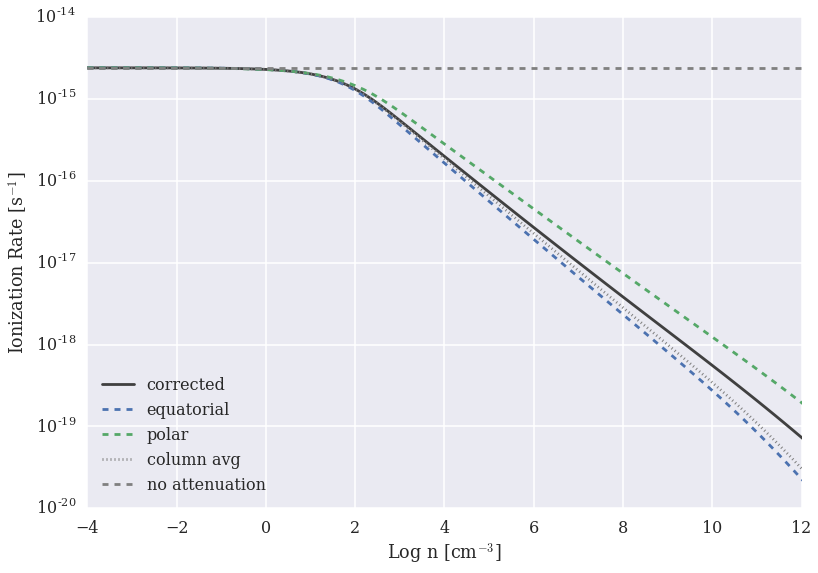

In [27]:
plt.plot(kh_rates.index, kh_rates.ion, label='corrected')
plt.plot(eq_kh_rates.index, eq_kh_rates.ion, '--', label='equatorial')
plt.plot(pole_kh_rates.index, pole_kh_rates.ion, '--', label='polar')
plt.plot(old_kh_rates.index, old_kh_rates.ion, ':', color='grey', label='column avg')
plt.plot(khr.index, khr.ion, '--', color='grey', label='no attenuation')
plt.yscale('log')
plt.ylim(1e-20)
plt.xlim(-4,12)
plt.legend(loc=0)
plt.xlabel('Log n [cm$^{-3}$]')
plt.ylabel('Ionization Rate [s$^{-1}$]')
plt.savefig('figures/khrates/ionrate.png', bbox_inches='tight')

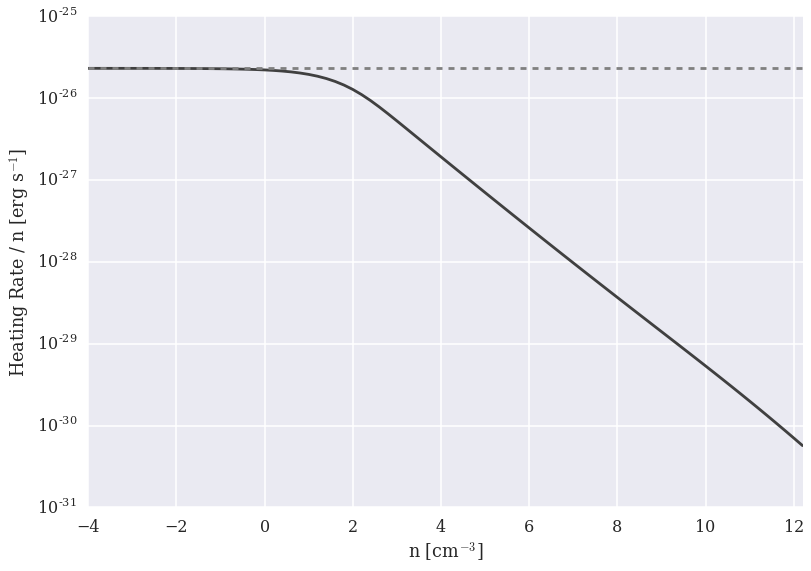

In [28]:
kh_rates['heat'].plot(logy=True)
plt.plot(khr.index, khr.heat, '--', color='grey')
plt.xlabel('n [cm$^{-3}$]')
plt.ylabel('Heating Rate / n [erg s$^{-1}$]')
plt.savefig('figures/khrates/hrate.png', bbox_inches='tight')

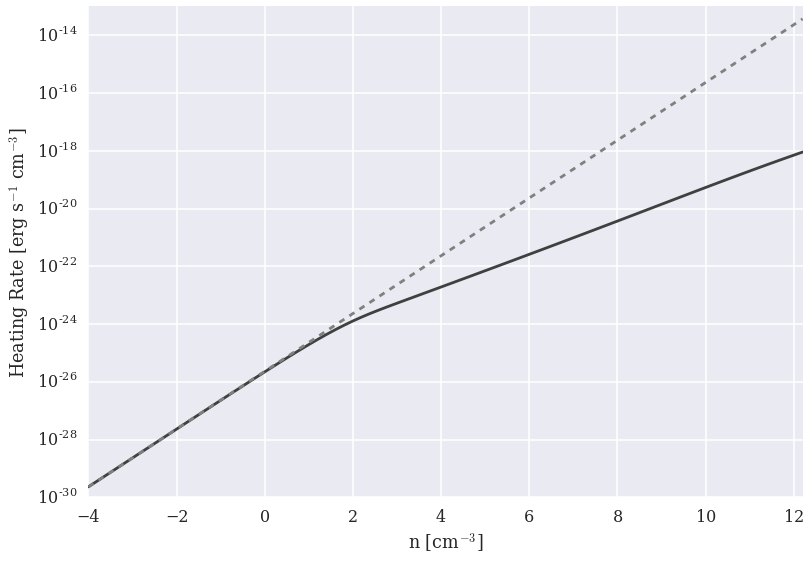

In [29]:
kh_rates['nheat'].plot(logy=True)
plt.plot(khr.index, khr.nheat, '--', color='grey')
plt.xlabel('n [cm$^{-3}$]')
plt.ylabel('Heating Rate [erg s$^{-1}$ cm$^{-3}$]')
plt.savefig('figures/khrates/nhrate.png', bbox_inches='tight')

In [30]:
Jxr = 2.70654888e-24 # Value from jxr.dat at z ~= 25
Ucr = 1.33554658e-06 # Value from ucr.dat at z ~= 25 * 6.24150934e11 to convert eV to erg
xr_rates = pd.read_csv('../../xrays/notebooks/kh_rates.csv', index_col=0) 
xrh = pd.read_csv('../../xrays/notebooks/khr.csv', index_col=0)
cr_rates = kh_rates[['ion', 'heat', 'nheat']]
crh = khr[['ion', 'heat', 'nheat']]

In [31]:
xr_rates.head()

,kH,kHe,kHeII,hH,hHe,hHeII,nhH,nhHe,nhHeII
-4.0,4504.802773,40519.964991,108863.924756,0.000009,0.00008,0.000211,8.984395e-10,8.027364e-10,2.112700e-12
-3.8,4504.801118,40519.929842,108863.674134,0.000009,0.00008,0.000211,1.423930e-09,1.272250e-09,3.348403e-12
-3.6,4504.798954,40519.884015,108863.347382,0.000009,0.00008,0.000211,2.256776e-09,2.016379e-09,5.306861e-12
-3.4,4504.796125,40519.824240,108862.921174,0.000009,0.00008,0.000211,3.576747e-09,3.195741e-09,8.410807e-12
-3.2,4504.792424,40519.746233,108862.364979,0.000009,0.00008,0.000211,5.668758e-09,5.064900e-09,1.333023e-11


In [32]:
xrh.head()

,kH,kHe,kHeII,hH,hHe,hHeII,nhH,nhHe,nhHeII
-4.0,4504.808216,40520.081687,108864.756825,0.000009,0.00008,0.000211,8.984405e-10,8.027385e-10,2.112700e-12
-3.8,4504.808216,40520.081687,108864.756825,0.000009,0.00008,0.000211,1.423932e-09,1.272255e-09,3.348404e-12
-3.6,4504.808216,40520.081687,108864.756825,0.000009,0.00008,0.000211,2.256780e-09,2.016388e-09,5.306862e-12
-3.4,4504.808216,40520.081687,108864.756825,0.000009,0.00008,0.000211,3.576756e-09,3.195760e-09,8.410809e-12
-3.2,4504.808216,40520.081687,108864.756825,0.000009,0.00008,0.000211,5.668776e-09,5.064938e-09,1.333023e-11


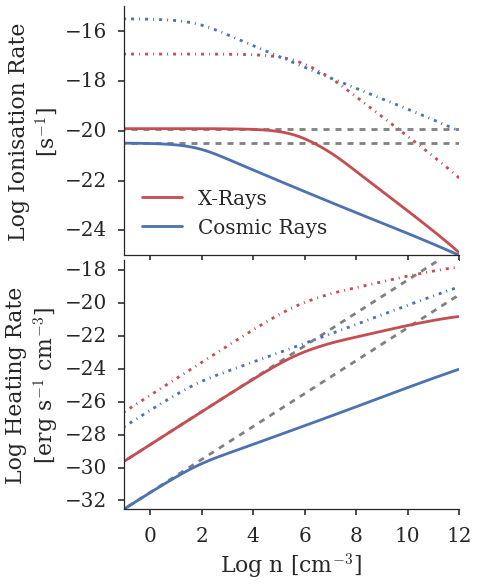

In [33]:
sns.set(context='poster', palette=palette, style='ticks', font='serif', font_scale=1.25)
crcolor = palette[1]
xrcolor = palette[3]
gray = '.5'
fig, (ax0,ax1) = plt.subplots(2, 1, sharex=True, figsize=(6,9))

ax0.plot(xrh.index, np.log10(xrh.kH*Jxr), '--', color=gray)
ax0.plot(crh.index, np.log10(crh.ion*Ucr), '--', color=gray)
xr, = ax0.plot(xr_rates.index, np.log10(xr_rates.kH*Jxr), color=xrcolor, label='X-Rays')
ax0.plot(xr_rates.index, np.log10(xr_rates.kH*Jxr*1e3), '-.', color=xrcolor)
cr, = ax0.plot(cr_rates.index, np.log10(cr_rates.ion*Ucr), color=crcolor, label='Cosmic Rays')
ax0.plot(cr_rates.index, np.log10(cr_rates.ion*Ucr*1e5), '-.', color=crcolor)
ax0.set_ylim(-25,-15)
ax0.legend(handles=[xr,cr], loc=0)
ax0.set_xlabel('Log n [cm$^{-3}$]')
ax0.set_ylabel('Log Ionisation Rate\n[s$^{-1}$]')
    
ax1.plot(xrh.index, np.log10(xrh.nhH*Jxr), '--', color=gray)
ax1.plot(crh.index, np.log10(crh.nheat*Ucr), '--', color=gray)
ax1.plot(xr_rates.index, np.log10(xr_rates.nhH*Jxr), color=xrcolor, label='X-Rays')
ax1.plot(xr_rates.index, np.log10(xr_rates.nhH*Jxr*1e3), '-.', color=xrcolor)
ax1.plot(cr_rates.index, np.log10(cr_rates.nheat*Ucr), color=crcolor, label='Cosmic Rays')
ax1.plot(cr_rates.index, np.log10(cr_rates.nheat*Ucr*1e5), '-.', color=crcolor)
ax1.set_ylim(-32.5, -17.4)
#ax1.legend(loc=0)
ax1.set_xlabel('Log n [cm$^{-3}$]')
ax1.set_ylabel('Log Heating Rate\n[erg s$^{-1}$ cm$^{-3}$]')

ax0.set_xlim(-1,12)
fig.subplots_adjust(hspace=0.02)
sns.despine()
fig.savefig('figures/khrates/khrates.pdf', bbox_inches='tight')

In [31]:
kh_data = np.column_stack((kh_rates.index.values, kh_rates[['ion', 'kHe', 'kHep', 'heat', 'hHe', 'hHep']].values))

In [32]:
kh_data.shape

(82, 7)

In [33]:
!head kh_rates.dat

-4.00000000e+00 2.40660371e-15 0.00000000e+00 0.00000000e+00 2.31348244e-26 0.00000000e+00 0.00000000e+00
-3.80000000e+00 2.40645486e-15 0.00000000e+00 0.00000000e+00 2.31333935e-26 0.00000000e+00 0.00000000e+00
-3.60000000e+00 2.40626035e-15 0.00000000e+00 0.00000000e+00 2.31315236e-26 0.00000000e+00 0.00000000e+00
-3.40000000e+00 2.40600608e-15 0.00000000e+00 0.00000000e+00 2.31290793e-26 0.00000000e+00 0.00000000e+00
-3.20000000e+00 2.40567355e-15 0.00000000e+00 0.00000000e+00 2.31258827e-26 0.00000000e+00 0.00000000e+00
-3.00000000e+00 2.40523850e-15 0.00000000e+00 0.00000000e+00 2.31217006e-26 0.00000000e+00 0.00000000e+00
-2.80000000e+00 2.40466910e-15 0.00000000e+00 0.00000000e+00 2.31162269e-26 0.00000000e+00 0.00000000e+00
-2.60000000e+00 2.40392359e-15 0.00000000e+00 0.00000000e+00 2.31090603e-26 0.00000000e+00 0.00000000e+00
-2.40000000e+00 2.40294718e-15 0.00000000e+00 0.00000000e+00 2.30996740e-26 0.00000000e+00 0.00000000e+00
-2.20000000e+00 2.40166799e-15 0.00000000e+00 

In [34]:
!tail kh_rates.dat

1.04000000e+01 3.76230753e-19 0.00000000e+00 0.00000000e+00 3.61672857e-30 0.00000000e+00 0.00000000e+00
1.06000000e+01 3.08662816e-19 0.00000000e+00 0.00000000e+00 2.96719398e-30 0.00000000e+00 0.00000000e+00
1.08000000e+01 2.52816467e-19 0.00000000e+00 0.00000000e+00 2.43033971e-30 0.00000000e+00 0.00000000e+00
1.10000000e+01 2.06704677e-19 0.00000000e+00 0.00000000e+00 1.98706433e-30 0.00000000e+00 0.00000000e+00
1.12000000e+01 1.68680915e-19 0.00000000e+00 0.00000000e+00 1.62153965e-30 0.00000000e+00 0.00000000e+00
1.14000000e+01 1.37376332e-19 0.00000000e+00 0.00000000e+00 1.32060684e-30 0.00000000e+00 0.00000000e+00
1.16000000e+01 1.11649442e-19 0.00000000e+00 0.00000000e+00 1.07329272e-30 0.00000000e+00 0.00000000e+00
1.18000000e+01 9.05462193e-20 0.00000000e+00 0.00000000e+00 8.70426184e-31 0.00000000e+00 0.00000000e+00
1.20000000e+01 7.32686444e-20 0.00000000e+00 0.00000000e+00 7.04335830e-31 0.00000000e+00 0.00000000e+00
1.22000000e+01 5.91497888e-20 0.00000000e+00 0.00000000